In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow import nn
from sklearn.preprocessing import normalize
from glob import glob
import os

In [2]:
path = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"
HEIGHT = 384
WIDTH = 576
trainFile = '03- train- Img only'
testFile = '04- test- Img only'
BATCH_SIZE = 32

[[  7  11  24 ...  25  10   7]
 [ 10 145 150 ... 150 143  10]
 [ 24 154 142 ... 143 155  27]
 ...
 [ 24 154 142 ... 143 155  27]
 [ 10 145 150 ... 150 143  10]
 [  7  11  24 ...  25  10   7]]


(384, 576)

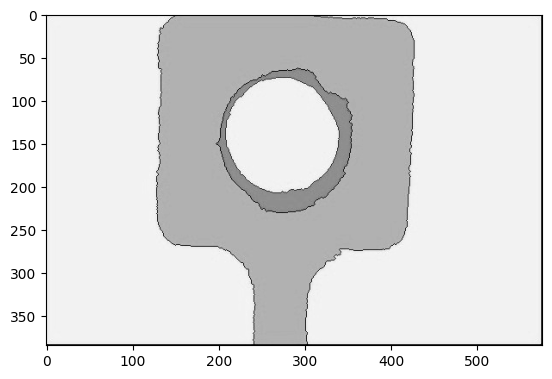

In [3]:
# file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\\train\Outputs\img\IMG_0467_blurred.JPG"
# img = cv2.imread(file)
# plt.imshow(img)
# img.shape

file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/03- train- Img only\Watershed Out\img\IMG_00074.jpg"
img = cv2.imread(file, 0)
print(img)
plt.imshow(img, cmap='gray')
img.shape[:]

In [4]:
seed = 42
BATCH_SIZE = 32
inputDataGen2 = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  )
#inputDataGen = ImageDataGenerator(rescale=1./255)

# inGen = inputDataGen.flow_from_directory(path + '\\01- train\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = inputDataGen.flow_from_directory(path + '\\01- train\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
inGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\03- train- Img only\\Fixture Mask', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')

sampleSize = inGen.samples

train_generator = zip(inGen, outGen)

Found 582 images belonging to 1 classes.
Found 582 images belonging to 1 classes.


In [5]:
# inGen = outputDataGen.flow_from_directory(path + '\\02- test\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
# outGen = outputDataGen.flow_from_directory(path + '\\02- test\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode="grayscale")
inGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Input', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen2.flow_from_directory(path + '\\04- test- Img only\\Fixture Mask', batch_size=BATCH_SIZE, target_size=(HEIGHT, WIDTH), class_mode=None, seed=seed, color_mode="grayscale")

test_generator = zip(inGen, outGen)

Found 198 images belonging to 1 classes.
Found 198 images belonging to 1 classes.


In [6]:
def double_conv_block(x, out_channels):
    x = layers.Conv2D(filters= out_channels, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters= out_channels, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x 

In [7]:
def downsample_block(x, out_channels):
    f = double_conv_block(x, out_channels)
    p = layers.MaxPool2D(pool_size=2, strides=2)(f)
    p = layers.Dropout(0.5)(p)
    return f, p

In [8]:
def upsample_block(x, conv_features, out_channels):
    x = layers.Conv2DTranspose(filters = out_channels, kernel_size=2, strides=2, padding='same')(x)
    x = layers.concatenate(inputs=[x, conv_features], axis=3)
    x = layers.Dropout(0.5)(x)
    x = double_conv_block(x, out_channels)
    return x

In [9]:
def build_unet_model():
    inputs = layers.Input(shape=(HEIGHT, WIDTH, 1))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = layers.MaxPool2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs, conv10)
    return model



In [10]:
class OutputPrinting(keras.callbacks.Callback):
    testFile1 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00703.JPG"
    testFile2 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00827.JPG"
    testFile3 = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_003.JPG"
    imgArr = [testFile1, testFile2, testFile3]
    
    def on_epoch_end(self, batch, logs=None):
        keys = list(logs.keys())
        
        fig = plt.figure(figsize=(3,2))

        for i in range(len(self.imgArr)):
            testImg = image.load_img(self.imgArr[i], color_mode='grayscale')
            testImg = np.expand_dims(testImg, axis=0)
            testImg = testImg/255
            imOut = self.model.predict(testImg)
            imOut = imOut.reshape(testImg.shape[1:3])
            testImg = testImg.reshape(testImg.shape[1:3])
            plt.subplot(3, 2, 2*i+1)
            plt.imshow(testImg, cmap='gray')
            plt.subplot(3, 2, 2*i+2)
            plt.imshow(imOut, cmap='gray')
            plt.axis('off')

        plt.show()

In [11]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):

    def __init__(self, patience=20):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None
        self.model_location = "W:\Advanced Engineering\Vortex Ballistics\~ACTIVE\Python Script\models\model 10-27_Fixture Mask-105 epochs-582 images"

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        self.model.save(self.model_location + '/' + str(epoch) + '.h5')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()    
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [12]:
unet_model = build_unet_model()
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 576, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 384, 576, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 384, 576, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 192, 288, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                   #loss = 'mse',
                   metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=False)

Epoch 1/107
1/1 [==============================] - 1s 829ms/step


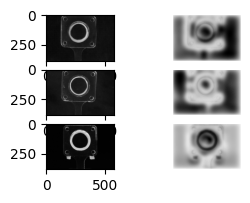

C:\Users\mimartin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1857s 103s/step - loss: 0.6802 - accuracy: 0.6866 - val_loss: 0.5958 - val_accuracy: 0.6877
Epoch 2/107
1/1 [==============================] - 1s 833ms/step


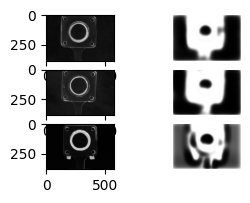

18/18 [==============================] - 1819s 106s/step - loss: 0.4687 - accuracy: 0.6864 - val_loss: 0.3673 - val_accuracy: 0.6891
Epoch 3/107
1/1 [==============================] - 1s 837ms/step


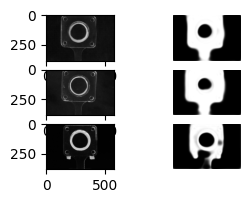

18/18 [==============================] - 1781s 99s/step - loss: 0.3155 - accuracy: 0.6897 - val_loss: 0.2875 - val_accuracy: 0.6869
Epoch 4/107
1/1 [==============================] - 1s 823ms/step


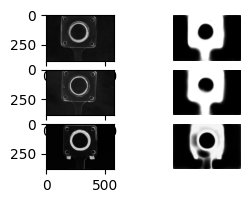

18/18 [==============================] - 1759s 98s/step - loss: 0.2883 - accuracy: 0.6913 - val_loss: 0.2726 - val_accuracy: 0.6845
Epoch 5/107
1/1 [==============================] - 1s 825ms/step


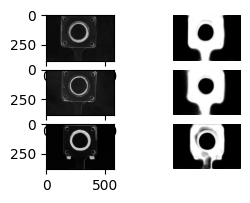

18/18 [==============================] - 1766s 98s/step - loss: 0.2579 - accuracy: 0.8115 - val_loss: 0.2582 - val_accuracy: 0.8578
Epoch 6/107
1/1 [==============================] - 1s 819ms/step


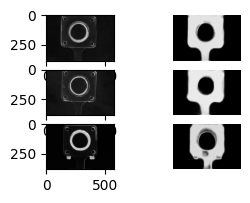

18/18 [==============================] - 1774s 99s/step - loss: 0.2373 - accuracy: 0.9128 - val_loss: 0.2361 - val_accuracy: 0.8957
Epoch 7/107
1/1 [==============================] - 1s 814ms/step


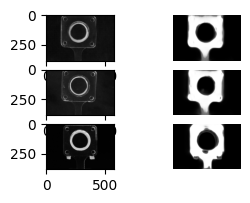

18/18 [==============================] - 1777s 99s/step - loss: 0.1150 - accuracy: 0.9237 - val_loss: 0.0877 - val_accuracy: 0.9176
Epoch 8/107
1/1 [==============================] - 1s 812ms/step


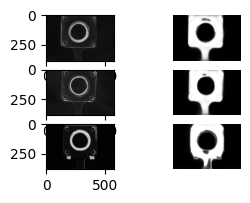

18/18 [==============================] - 1776s 99s/step - loss: 0.0933 - accuracy: 0.9173 - val_loss: 0.0709 - val_accuracy: 0.9298
Epoch 9/107
1/1 [==============================] - 1s 826ms/step


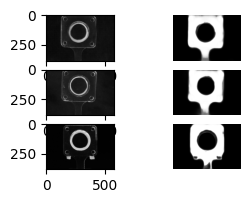

18/18 [==============================] - 1778s 99s/step - loss: 0.0615 - accuracy: 0.9299 - val_loss: 0.0667 - val_accuracy: 0.9323
Epoch 10/107
1/1 [==============================] - 1s 829ms/step


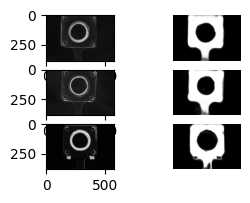

18/18 [==============================] - 1779s 99s/step - loss: 0.0469 - accuracy: 0.9353 - val_loss: 0.0542 - val_accuracy: 0.9353
Epoch 11/107
1/1 [==============================] - 1s 881ms/step


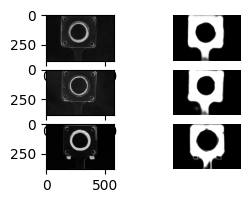

18/18 [==============================] - 1808s 101s/step - loss: 0.0376 - accuracy: 0.9376 - val_loss: 0.0526 - val_accuracy: 0.9323
Epoch 12/107
1/1 [==============================] - 1s 832ms/step


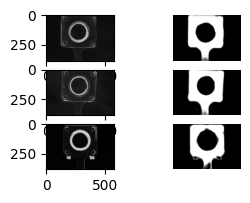

18/18 [==============================] - 1784s 99s/step - loss: 0.0331 - accuracy: 0.9389 - val_loss: 0.0443 - val_accuracy: 0.9366
Epoch 13/107
1/1 [==============================] - 1s 833ms/step


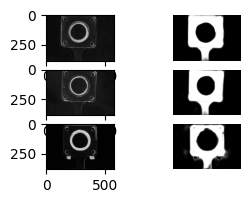

18/18 [==============================] - 1781s 99s/step - loss: 0.0291 - accuracy: 0.9397 - val_loss: 0.0389 - val_accuracy: 0.9390
Epoch 14/107
1/1 [==============================] - 1s 837ms/step


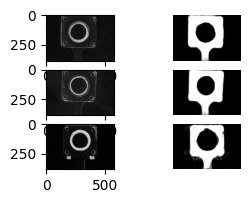

18/18 [==============================] - 1784s 99s/step - loss: 0.0274 - accuracy: 0.9409 - val_loss: 0.0347 - val_accuracy: 0.9396
Epoch 15/107
1/1 [==============================] - 1s 819ms/step


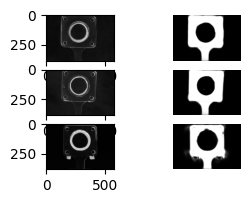

18/18 [==============================] - 1784s 99s/step - loss: 0.0253 - accuracy: 0.9411 - val_loss: 0.0330 - val_accuracy: 0.9411
Epoch 16/107
1/1 [==============================] - 1s 836ms/step


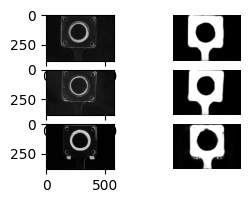

18/18 [==============================] - 1786s 99s/step - loss: 0.0250 - accuracy: 0.9408 - val_loss: 0.0338 - val_accuracy: 0.9401
Epoch 17/107
1/1 [==============================] - 1s 839ms/step


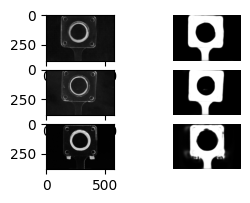

18/18 [==============================] - 1787s 100s/step - loss: 0.0234 - accuracy: 0.9416 - val_loss: 0.0288 - val_accuracy: 0.9411
Epoch 18/107
1/1 [==============================] - 1s 832ms/step


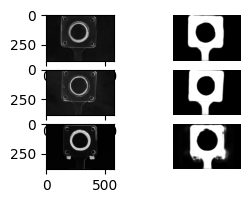

18/18 [==============================] - 1786s 99s/step - loss: 0.0227 - accuracy: 0.9413 - val_loss: 0.0292 - val_accuracy: 0.9404
Epoch 19/107
1/1 [==============================] - 1s 819ms/step


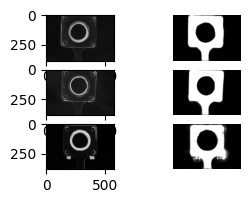

18/18 [==============================] - 1789s 100s/step - loss: 0.0220 - accuracy: 0.9418 - val_loss: 0.0285 - val_accuracy: 0.9415
Epoch 20/107
1/1 [==============================] - 1s 827ms/step


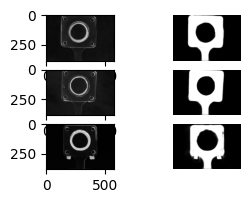

18/18 [==============================] - 1888s 105s/step - loss: 0.0210 - accuracy: 0.9416 - val_loss: 0.0247 - val_accuracy: 0.9415
Epoch 21/107
1/1 [==============================] - 1s 837ms/step


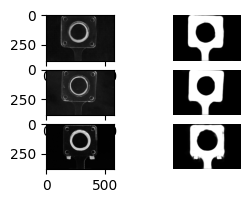

18/18 [==============================] - 1794s 104s/step - loss: 0.0196 - accuracy: 0.9424 - val_loss: 0.0244 - val_accuracy: 0.9415
Epoch 22/107
1/1 [==============================] - 1s 840ms/step


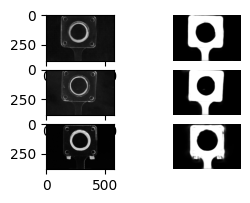

18/18 [==============================] - 1792s 100s/step - loss: 0.0202 - accuracy: 0.9428 - val_loss: 0.0254 - val_accuracy: 0.9419
Epoch 23/107
1/1 [==============================] - 1s 826ms/step


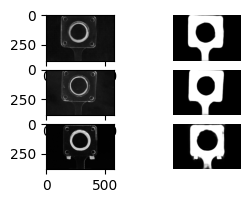

18/18 [==============================] - 1793s 100s/step - loss: 0.0194 - accuracy: 0.9425 - val_loss: 0.0236 - val_accuracy: 0.9424
Epoch 24/107
1/1 [==============================] - 1s 859ms/step


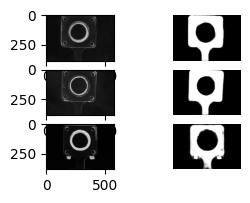

18/18 [==============================] - 1804s 101s/step - loss: 0.0186 - accuracy: 0.9429 - val_loss: 0.0220 - val_accuracy: 0.9429
Epoch 25/107
1/1 [==============================] - 1s 844ms/step


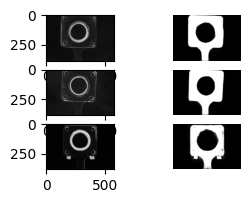

18/18 [==============================] - 1810s 101s/step - loss: 0.0184 - accuracy: 0.9428 - val_loss: 0.0238 - val_accuracy: 0.9423
Epoch 26/107
1/1 [==============================] - 1s 853ms/step


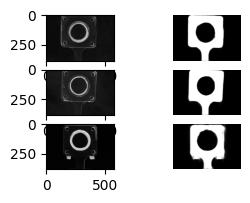

18/18 [==============================] - 1795s 100s/step - loss: 0.0177 - accuracy: 0.9435 - val_loss: 0.0245 - val_accuracy: 0.9432
Epoch 27/107
1/1 [==============================] - 1s 891ms/step


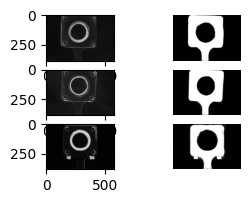

18/18 [==============================] - 1801s 100s/step - loss: 0.0178 - accuracy: 0.9429 - val_loss: 0.0219 - val_accuracy: 0.9423
Epoch 28/107
1/1 [==============================] - 1s 834ms/step


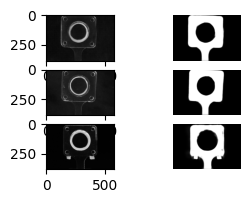

18/18 [==============================] - 1798s 100s/step - loss: 0.0172 - accuracy: 0.9432 - val_loss: 0.0200 - val_accuracy: 0.9431
Epoch 29/107
1/1 [==============================] - 1s 836ms/step


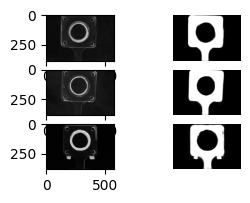

18/18 [==============================] - 1796s 100s/step - loss: 0.0168 - accuracy: 0.9433 - val_loss: 0.0195 - val_accuracy: 0.9430
Epoch 30/107
1/1 [==============================] - 1s 837ms/step


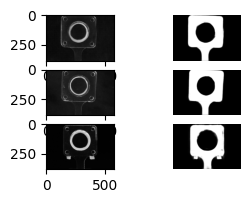

18/18 [==============================] - 1792s 100s/step - loss: 0.0168 - accuracy: 0.9431 - val_loss: 0.0220 - val_accuracy: 0.9418
Epoch 31/107
1/1 [==============================] - 1s 834ms/step


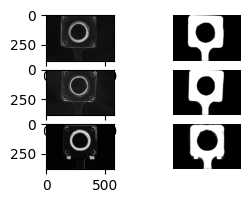

18/18 [==============================] - 1792s 100s/step - loss: 0.0163 - accuracy: 0.9431 - val_loss: 0.0212 - val_accuracy: 0.9433
Epoch 32/107
1/1 [==============================] - 1s 912ms/step


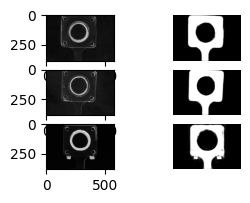

18/18 [==============================] - 1815s 101s/step - loss: 0.0161 - accuracy: 0.9430 - val_loss: 0.0187 - val_accuracy: 0.9426
Epoch 33/107
1/1 [==============================] - 1s 822ms/step


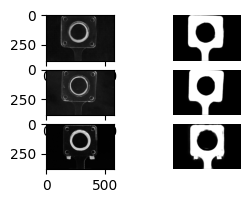

18/18 [==============================] - 1804s 100s/step - loss: 0.0156 - accuracy: 0.9435 - val_loss: 0.0219 - val_accuracy: 0.9417
Epoch 34/107
1/1 [==============================] - 1s 867ms/step


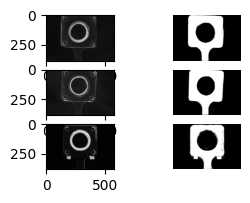

18/18 [==============================] - 1794s 100s/step - loss: 0.0158 - accuracy: 0.9429 - val_loss: 0.0188 - val_accuracy: 0.9436
Epoch 35/107
1/1 [==============================] - 1s 838ms/step


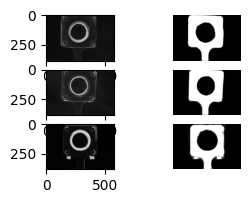

18/18 [==============================] - 1794s 100s/step - loss: 0.0158 - accuracy: 0.9433 - val_loss: 0.0173 - val_accuracy: 0.9437
Epoch 36/107
1/1 [==============================] - 1s 825ms/step


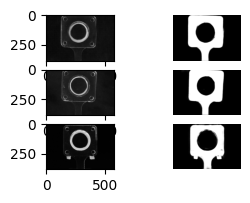

18/18 [==============================] - 1793s 100s/step - loss: 0.0153 - accuracy: 0.9430 - val_loss: 0.0189 - val_accuracy: 0.9430
Epoch 37/107
1/1 [==============================] - 1s 847ms/step


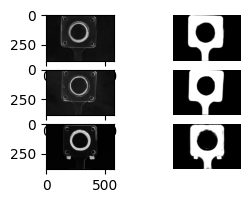

18/18 [==============================] - 1794s 100s/step - loss: 0.0153 - accuracy: 0.9429 - val_loss: 0.0161 - val_accuracy: 0.9432
Epoch 38/107
1/1 [==============================] - 1s 846ms/step


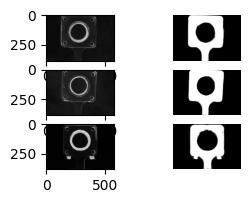

18/18 [==============================] - 1793s 100s/step - loss: 0.0154 - accuracy: 0.9436 - val_loss: 0.0166 - val_accuracy: 0.9431
Epoch 39/107
1/1 [==============================] - 1s 821ms/step


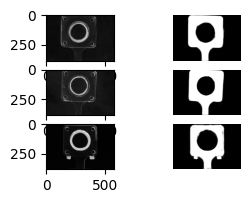

18/18 [==============================] - 1875s 105s/step - loss: 0.0150 - accuracy: 0.9437 - val_loss: 0.0212 - val_accuracy: 0.9422
Epoch 40/107
1/1 [==============================] - 1s 837ms/step


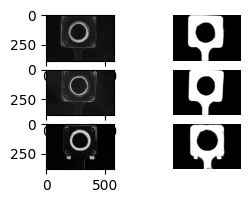

18/18 [==============================] - 1792s 104s/step - loss: 0.0150 - accuracy: 0.9432 - val_loss: 0.0210 - val_accuracy: 0.9418
Epoch 41/107
1/1 [==============================] - 1s 847ms/step


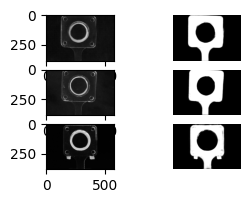

18/18 [==============================] - 1825s 102s/step - loss: 0.0151 - accuracy: 0.9431 - val_loss: 0.0196 - val_accuracy: 0.9427
Epoch 42/107
1/1 [==============================] - 1s 857ms/step


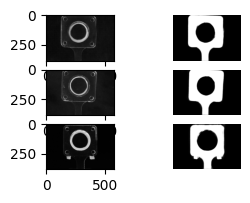

18/18 [==============================] - 1795s 100s/step - loss: 0.0150 - accuracy: 0.9431 - val_loss: 0.0193 - val_accuracy: 0.9421
Epoch 43/107
1/1 [==============================] - 1s 851ms/step


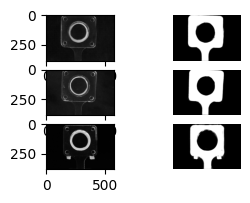

18/18 [==============================] - 1800s 100s/step - loss: 0.0150 - accuracy: 0.9435 - val_loss: 0.0207 - val_accuracy: 0.9417
Epoch 44/107
1/1 [==============================] - 1s 857ms/step


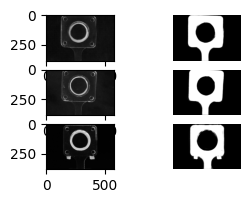

18/18 [==============================] - 1795s 100s/step - loss: 0.0146 - accuracy: 0.9432 - val_loss: 0.0175 - val_accuracy: 0.9433
Epoch 45/107
1/1 [==============================] - 1s 851ms/step


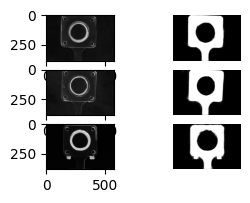

18/18 [==============================] - 1803s 100s/step - loss: 0.0149 - accuracy: 0.9430 - val_loss: 0.0207 - val_accuracy: 0.9418
Epoch 46/107
1/1 [==============================] - 1s 841ms/step


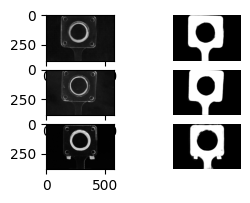

18/18 [==============================] - 1801s 100s/step - loss: 0.0149 - accuracy: 0.9434 - val_loss: 0.0167 - val_accuracy: 0.9426
Epoch 47/107
1/1 [==============================] - 1s 874ms/step


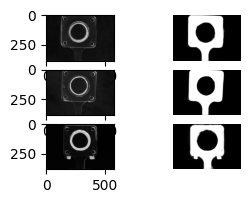

18/18 [==============================] - 1808s 101s/step - loss: 0.0152 - accuracy: 0.9432 - val_loss: 0.0178 - val_accuracy: 0.9429
Epoch 48/107
1/1 [==============================] - 1s 838ms/step


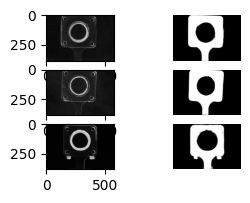

18/18 [==============================] - 1817s 101s/step - loss: 0.0149 - accuracy: 0.9432 - val_loss: 0.0153 - val_accuracy: 0.9442
Epoch 49/107
1/1 [==============================] - 1s 838ms/step


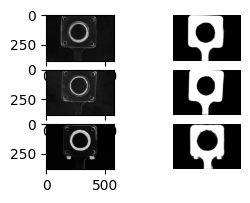

18/18 [==============================] - 1829s 102s/step - loss: 0.0147 - accuracy: 0.9431 - val_loss: 0.0177 - val_accuracy: 0.9423
Epoch 50/107
1/1 [==============================] - 1s 859ms/step


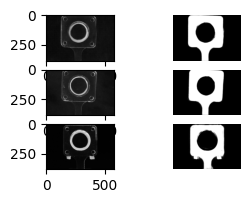

18/18 [==============================] - 1809s 101s/step - loss: 0.0143 - accuracy: 0.9432 - val_loss: 0.0172 - val_accuracy: 0.9439
Epoch 51/107
1/1 [==============================] - 1s 838ms/step


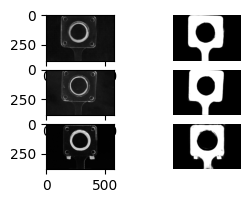

18/18 [==============================] - 1808s 101s/step - loss: 0.0141 - accuracy: 0.9430 - val_loss: 0.0171 - val_accuracy: 0.9421
Epoch 52/107
1/1 [==============================] - 1s 833ms/step


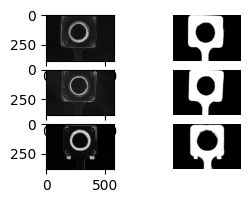

18/18 [==============================] - 1810s 101s/step - loss: 0.0141 - accuracy: 0.9436 - val_loss: 0.0182 - val_accuracy: 0.9416
Epoch 53/107
1/1 [==============================] - 1s 841ms/step


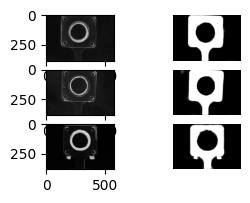

18/18 [==============================] - 1811s 101s/step - loss: 0.0144 - accuracy: 0.9435 - val_loss: 0.0201 - val_accuracy: 0.9416
Epoch 54/107
1/1 [==============================] - 1s 848ms/step


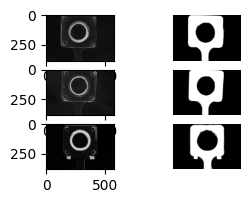

18/18 [==============================] - 1815s 101s/step - loss: 0.0142 - accuracy: 0.9436 - val_loss: 0.0207 - val_accuracy: 0.9423
Epoch 55/107
1/1 [==============================] - 1s 851ms/step


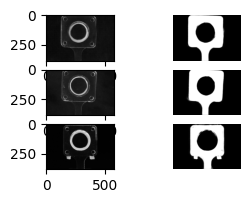

18/18 [==============================] - 1810s 101s/step - loss: 0.0142 - accuracy: 0.9437 - val_loss: 0.0175 - val_accuracy: 0.9439
Epoch 56/107
1/1 [==============================] - 1s 836ms/step


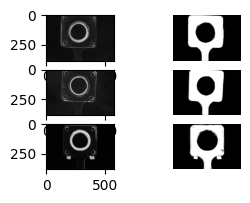

18/18 [==============================] - 1810s 101s/step - loss: 0.0139 - accuracy: 0.9434 - val_loss: 0.0177 - val_accuracy: 0.9430
Epoch 57/107
1/1 [==============================] - 1s 902ms/step


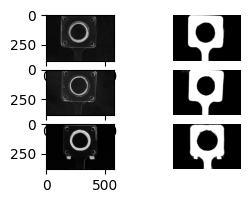

18/18 [==============================] - 1819s 101s/step - loss: 0.0143 - accuracy: 0.9435 - val_loss: 0.0186 - val_accuracy: 0.9421
Epoch 58/107
1/1 [==============================] - 1s 851ms/step


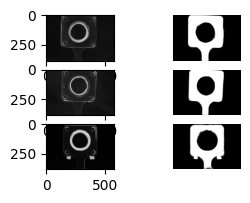

18/18 [==============================] - 1906s 106s/step - loss: 0.0140 - accuracy: 0.9432 - val_loss: 0.0180 - val_accuracy: 0.9437
Epoch 59/107
1/1 [==============================] - 1s 843ms/step


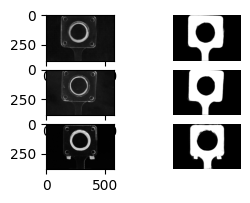

18/18 [==============================] - 1814s 106s/step - loss: 0.0139 - accuracy: 0.9435 - val_loss: 0.0182 - val_accuracy: 0.9430
Epoch 60/107
1/1 [==============================] - 1s 862ms/step


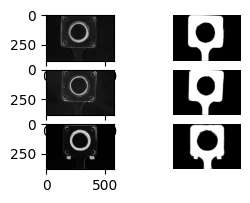

18/18 [==============================] - 1811s 101s/step - loss: 0.0137 - accuracy: 0.9434 - val_loss: 0.0147 - val_accuracy: 0.9435
Epoch 61/107
1/1 [==============================] - 1s 850ms/step


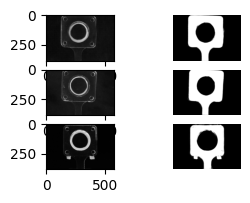

18/18 [==============================] - 1812s 101s/step - loss: 0.0137 - accuracy: 0.9439 - val_loss: 0.0140 - val_accuracy: 0.9440
Epoch 62/107
1/1 [==============================] - 1s 849ms/step


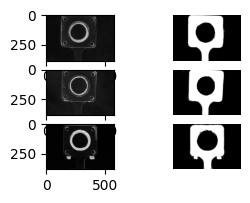

18/18 [==============================] - 1813s 101s/step - loss: 0.0135 - accuracy: 0.9439 - val_loss: 0.0163 - val_accuracy: 0.9431
Epoch 63/107
1/1 [==============================] - 1s 854ms/step


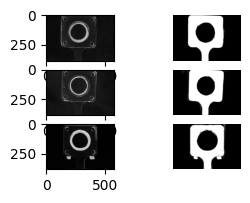

18/18 [==============================] - 1812s 101s/step - loss: 0.0143 - accuracy: 0.9430 - val_loss: 0.0193 - val_accuracy: 0.9422
Epoch 64/107
1/1 [==============================] - 1s 860ms/step


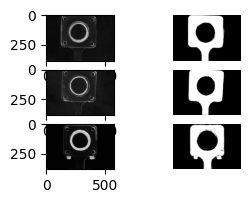

18/18 [==============================] - 1818s 101s/step - loss: 0.0143 - accuracy: 0.9434 - val_loss: 0.0150 - val_accuracy: 0.9440
Epoch 65/107
1/1 [==============================] - 1s 846ms/step


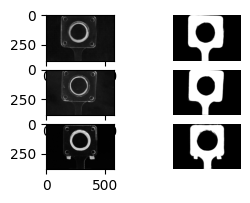

18/18 [==============================] - 1813s 101s/step - loss: 0.0140 - accuracy: 0.9435 - val_loss: 0.0184 - val_accuracy: 0.9433
Epoch 66/107
1/1 [==============================] - 1s 914ms/step


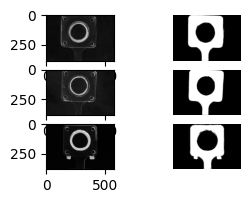

18/18 [==============================] - 1838s 102s/step - loss: 0.0136 - accuracy: 0.9435 - val_loss: 0.0180 - val_accuracy: 0.9436
Epoch 67/107
1/1 [==============================] - 1s 849ms/step


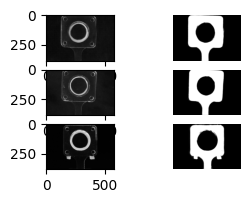

18/18 [==============================] - 1816s 101s/step - loss: 0.0133 - accuracy: 0.9439 - val_loss: 0.0213 - val_accuracy: 0.9439
Epoch 68/107
1/1 [==============================] - 1s 858ms/step


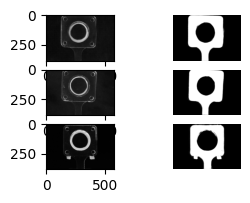

18/18 [==============================] - 1814s 101s/step - loss: 0.0135 - accuracy: 0.9442 - val_loss: 0.0162 - val_accuracy: 0.9428
Epoch 69/107
1/1 [==============================] - 1s 840ms/step


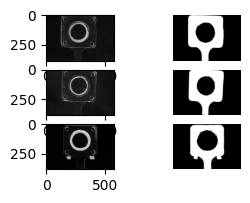

18/18 [==============================] - 1817s 101s/step - loss: 0.0134 - accuracy: 0.9429 - val_loss: 0.0187 - val_accuracy: 0.9434
Epoch 70/107
1/1 [==============================] - 1s 845ms/step


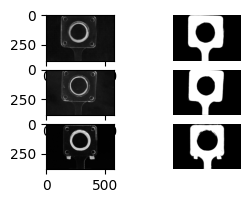

18/18 [==============================] - 1813s 101s/step - loss: 0.0134 - accuracy: 0.9437 - val_loss: 0.0161 - val_accuracy: 0.9432
Epoch 71/107
1/1 [==============================] - 1s 868ms/step


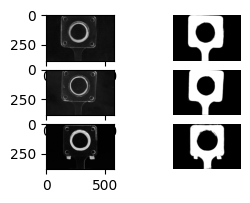

18/18 [==============================] - 1812s 101s/step - loss: 0.0136 - accuracy: 0.9432 - val_loss: 0.0141 - val_accuracy: 0.9435
Epoch 72/107
1/1 [==============================] - 1s 842ms/step


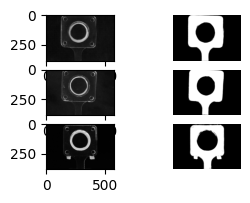

18/18 [==============================] - 1811s 101s/step - loss: 0.0136 - accuracy: 0.9430 - val_loss: 0.0177 - val_accuracy: 0.9435
Epoch 73/107
1/1 [==============================] - 1s 854ms/step


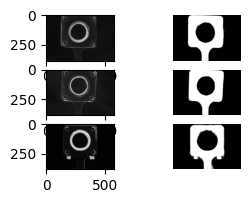

18/18 [==============================] - 1816s 101s/step - loss: 0.0134 - accuracy: 0.9437 - val_loss: 0.0140 - val_accuracy: 0.9436
Epoch 74/107
1/1 [==============================] - 1s 848ms/step


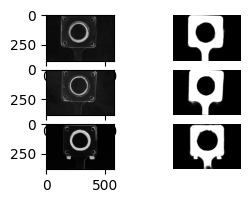

18/18 [==============================] - 1836s 102s/step - loss: 0.0135 - accuracy: 0.9436 - val_loss: 0.0200 - val_accuracy: 0.9420
Epoch 75/107
1/1 [==============================] - 1s 841ms/step


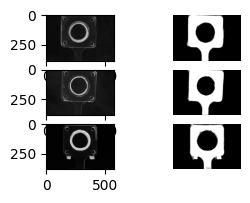

18/18 [==============================] - 1810s 101s/step - loss: 0.0155 - accuracy: 0.9429 - val_loss: 0.0262 - val_accuracy: 0.9401
Epoch 76/107
1/1 [==============================] - 1s 894ms/step


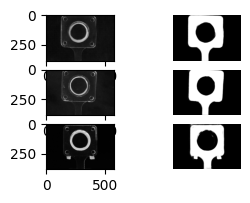

18/18 [==============================] - 1806s 101s/step - loss: 0.0159 - accuracy: 0.9435 - val_loss: 0.0185 - val_accuracy: 0.9426
Epoch 77/107
1/1 [==============================] - 1s 851ms/step


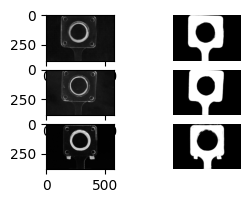

18/18 [==============================] - 1889s 105s/step - loss: 0.0152 - accuracy: 0.9431 - val_loss: 0.0189 - val_accuracy: 0.9441
Epoch 78/107
1/1 [==============================] - 1s 850ms/step


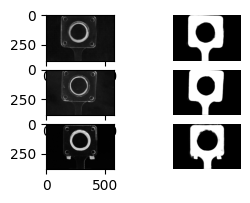

18/18 [==============================] - 1807s 105s/step - loss: 0.0141 - accuracy: 0.9431 - val_loss: 0.0180 - val_accuracy: 0.9427
Epoch 79/107
1/1 [==============================] - 1s 914ms/step


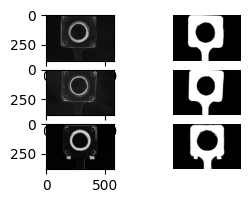

18/18 [==============================] - 1814s 101s/step - loss: 0.0136 - accuracy: 0.9434 - val_loss: 0.0162 - val_accuracy: 0.9423
Epoch 80/107
1/1 [==============================] - 1s 850ms/step


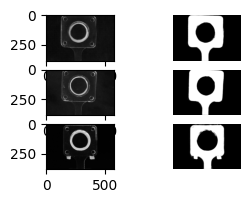

18/18 [==============================] - 1815s 101s/step - loss: 0.0133 - accuracy: 0.9437 - val_loss: 0.0136 - val_accuracy: 0.9452
Epoch 81/107
1/1 [==============================] - 1s 839ms/step


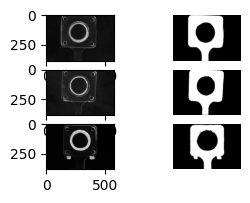

18/18 [==============================] - 1813s 101s/step - loss: 0.0134 - accuracy: 0.9430 - val_loss: 0.0138 - val_accuracy: 0.9440
Epoch 82/107
1/1 [==============================] - 1s 896ms/step


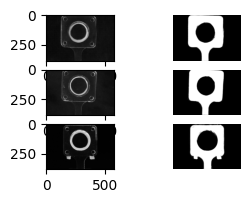

18/18 [==============================] - 1824s 102s/step - loss: 0.0134 - accuracy: 0.9437 - val_loss: 0.0154 - val_accuracy: 0.9440
Epoch 83/107
1/1 [==============================] - 1s 866ms/step


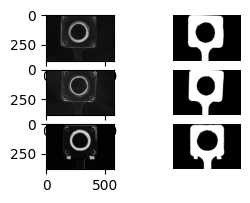

18/18 [==============================] - 1832s 102s/step - loss: 0.0130 - accuracy: 0.9442 - val_loss: 0.0136 - val_accuracy: 0.9440
Epoch 84/107
1/1 [==============================] - 1s 845ms/step


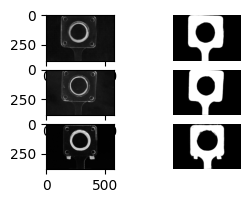

18/18 [==============================] - 1813s 101s/step - loss: 0.0131 - accuracy: 0.9438 - val_loss: 0.0157 - val_accuracy: 0.9434
Epoch 85/107
1/1 [==============================] - 1s 853ms/step


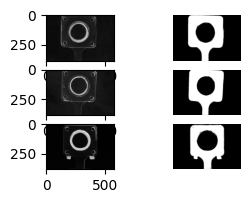

18/18 [==============================] - 1815s 101s/step - loss: 0.0136 - accuracy: 0.9431 - val_loss: 0.0136 - val_accuracy: 0.9442
Epoch 86/107
1/1 [==============================] - 1s 837ms/step


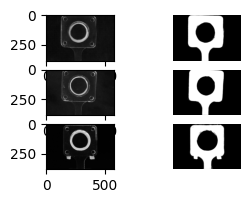

18/18 [==============================] - 1814s 101s/step - loss: 0.0132 - accuracy: 0.9434 - val_loss: 0.0169 - val_accuracy: 0.9430
Epoch 87/107
1/1 [==============================] - 1s 847ms/step


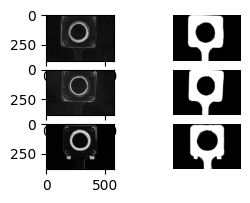

18/18 [==============================] - 1818s 101s/step - loss: 0.0134 - accuracy: 0.9437 - val_loss: 0.0132 - val_accuracy: 0.9435
Epoch 88/107
1/1 [==============================] - 1s 860ms/step


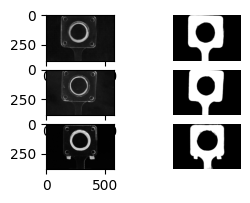

18/18 [==============================] - 1820s 101s/step - loss: 0.0132 - accuracy: 0.9434 - val_loss: 0.0188 - val_accuracy: 0.9423
Epoch 89/107
1/1 [==============================] - 1s 845ms/step


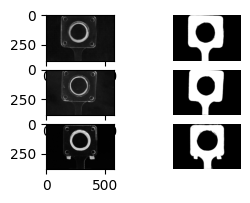

18/18 [==============================] - 1820s 101s/step - loss: 0.0131 - accuracy: 0.9434 - val_loss: 0.0135 - val_accuracy: 0.9446
Epoch 90/107
1/1 [==============================] - 1s 860ms/step


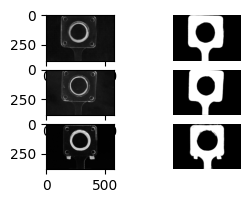

18/18 [==============================] - 1816s 101s/step - loss: 0.0132 - accuracy: 0.9430 - val_loss: 0.0181 - val_accuracy: 0.9424
Epoch 91/107
1/1 [==============================] - 1s 850ms/step


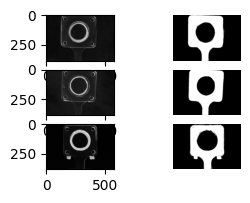

18/18 [==============================] - 1842s 103s/step - loss: 0.0131 - accuracy: 0.9440 - val_loss: 0.0180 - val_accuracy: 0.9432
Epoch 92/107
1/1 [==============================] - 1s 854ms/step


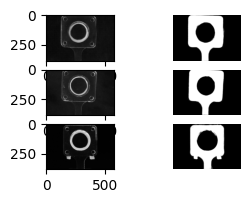

18/18 [==============================] - 1813s 101s/step - loss: 0.0131 - accuracy: 0.9430 - val_loss: 0.0186 - val_accuracy: 0.9429
Epoch 93/107
1/1 [==============================] - 1s 843ms/step


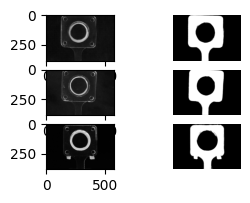

18/18 [==============================] - 1817s 101s/step - loss: 0.0132 - accuracy: 0.9434 - val_loss: 0.0177 - val_accuracy: 0.9427
Epoch 94/107
1/1 [==============================] - 1s 841ms/step


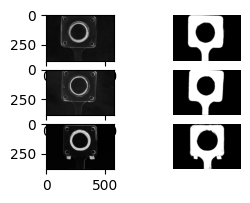

18/18 [==============================] - 1815s 101s/step - loss: 0.0129 - accuracy: 0.9440 - val_loss: 0.0194 - val_accuracy: 0.9425
Epoch 95/107
1/1 [==============================] - 1s 848ms/step


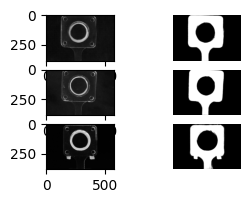

18/18 [==============================] - 1815s 101s/step - loss: 0.0130 - accuracy: 0.9436 - val_loss: 0.0154 - val_accuracy: 0.9433
Epoch 96/107
1/1 [==============================] - 1s 840ms/step


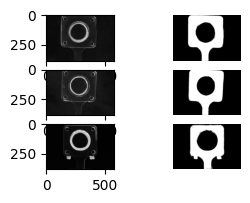

18/18 [==============================] - 1891s 106s/step - loss: 0.0130 - accuracy: 0.9438 - val_loss: 0.0134 - val_accuracy: 0.9440
Epoch 97/107
1/1 [==============================] - 1s 864ms/step


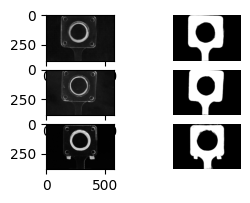

18/18 [==============================] - 1817s 106s/step - loss: 0.0130 - accuracy: 0.9436 - val_loss: 0.0166 - val_accuracy: 0.9452
Epoch 98/107
1/1 [==============================] - 1s 833ms/step


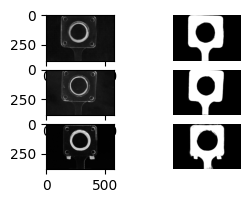

18/18 [==============================] - 1813s 101s/step - loss: 0.0133 - accuracy: 0.9432 - val_loss: 0.0173 - val_accuracy: 0.9436
Epoch 99/107
1/1 [==============================] - 1s 858ms/step


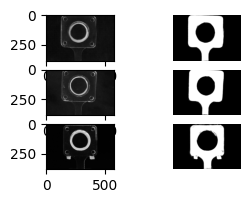

18/18 [==============================] - 1838s 102s/step - loss: 0.0131 - accuracy: 0.9437 - val_loss: 0.0178 - val_accuracy: 0.9431
Epoch 100/107
1/1 [==============================] - 1s 843ms/step


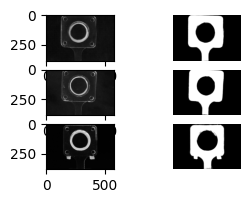

18/18 [==============================] - 1814s 101s/step - loss: 0.0131 - accuracy: 0.9432 - val_loss: 0.0156 - val_accuracy: 0.9437
Epoch 101/107
1/1 [==============================] - 1s 867ms/step


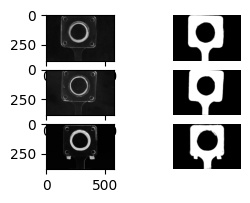

18/18 [==============================] - 1812s 101s/step - loss: 0.0129 - accuracy: 0.9438 - val_loss: 0.0163 - val_accuracy: 0.9440
Epoch 102/107
1/1 [==============================] - 1s 864ms/step


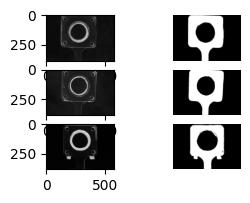

18/18 [==============================] - 1825s 102s/step - loss: 0.0130 - accuracy: 0.9430 - val_loss: 0.0179 - val_accuracy: 0.9428
Epoch 103/107
1/1 [==============================] - 1s 846ms/step


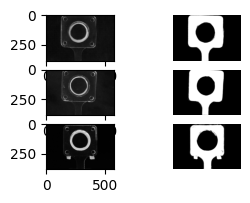

18/18 [==============================] - 1815s 101s/step - loss: 0.0126 - accuracy: 0.9439 - val_loss: 0.0161 - val_accuracy: 0.9438
Epoch 104/107
1/1 [==============================] - 1s 862ms/step


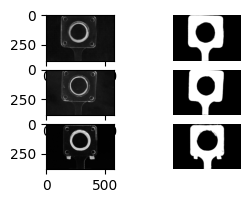

18/18 [==============================] - 1817s 101s/step - loss: 0.0129 - accuracy: 0.9440 - val_loss: 0.0179 - val_accuracy: 0.9433
Epoch 105/107
1/1 [==============================] - 1s 840ms/step


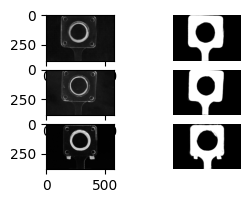

18/18 [==============================] - 1815s 101s/step - loss: 0.0127 - accuracy: 0.9434 - val_loss: 0.0143 - val_accuracy: 0.9440
Epoch 106/107
1/1 [==============================] - 1s 843ms/step


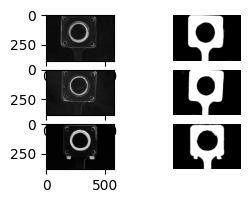

18/18 [==============================] - 1815s 101s/step - loss: 0.0128 - accuracy: 0.9437 - val_loss: 0.0163 - val_accuracy: 0.9430
Epoch 107/107
1/1 [==============================] - 1s 892ms/step


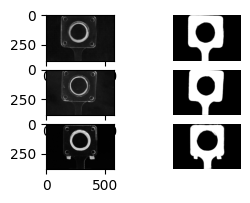

Restoring model weights from the end of the best epoch.
18/18 [==============================] - 1825s 102s/step - loss: 0.0130 - accuracy: 0.9428 - val_loss: 0.0166 - val_accuracy: 0.9431
Epoch 00107: early stopping


In [14]:
BUFFER_SIZE = 1000
NUM_EPOCHS = 107

TRAIN_LENGTH = 213
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = 13

VAL_SUBSPLITS = 5
TEST_LENTH = 27
#VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 5

#model_history = unet_model.fit(train_generator,
#                               epochs=NUM_EPOCHS,
#                               steps_per_epoch= sampleSize//BATCH_SIZE,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=test_generator,
#                               #callbacks=[es]
#                              )

model_history = unet_model.fit(train_generator,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch= sampleSize//BATCH_SIZE,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_generator,
                               callbacks=[OutputPrinting(), EarlyStoppingAtMinLoss()]
                               )

In [15]:
testFile = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/00- Full Image Dataset\IMG_00718.JPG"
testImg = image.load_img(testFile, color_mode='grayscale')
testImg = np.expand_dims(testImg, axis=0)
testImg = testImg/255
testImg = testImg
imOut = unet_model.predict(testImg)

1/1 [==============================] - 1s 884ms/step


[[3.7887890e-02 7.5254459e-03 5.8371981e-04 ... 2.9212690e-04
  5.3210435e-03 4.8491944e-02]
 [1.1508638e-02 3.2581051e-04 2.7357186e-05 ... 1.5877526e-06
  1.2580895e-04 1.5083959e-02]
 [5.3677545e-03 2.9388320e-04 4.2576339e-06 ... 1.1869657e-07
  9.6819776e-06 2.1930565e-03]
 ...
 [6.7634983e-03 1.0975488e-04 7.2918019e-06 ... 2.6508297e-07
  1.7493579e-05 2.0494962e-02]
 [1.7087767e-02 5.8854121e-04 6.2807398e-05 ... 4.7191375e-06
  1.4270362e-04 8.9654727e-03]
 [1.1288911e-01 1.7444601e-02 4.0700240e-03 ... 5.7590654e-04
  4.2567835e-03 3.9570563e-02]]


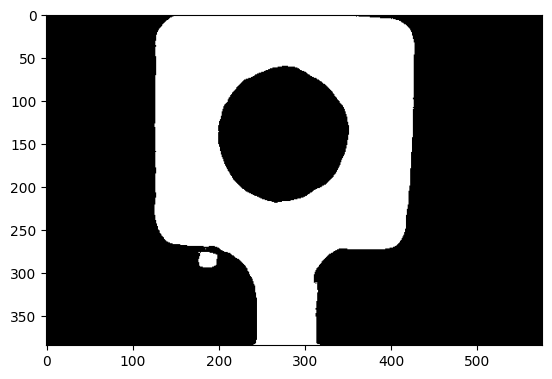

In [16]:
imOut = imOut.reshape(testImg.shape[1:3])
print(imOut)
normalizedArr = tf.keras.utils.normalize(imOut)
predicted_mask = (normalizedArr > .104).astype(np.uint32)
plt.imshow(imOut>0.16, cmap='gray')